# KNN On Amazon Fine Food Reviews:



In [ ]:
=> Predictions:

The purpose of this analysis is to make up a prediction model where we will 
be able to predict whether a recommendation is positive or negative. In this
analysis, we will not focus on the Score, but only the positive/negative 
sentiment of the recommendation.To do so, we will work on Amazon's 
recommendation dataset, we will build a Term-doc incidence matrix 
using term frequency and inverse document frequency ponderation.

When the data is ready, we will load it into predicitve algorithms, 
mainly naïve Bayesianand regression.In the end, we hope to find a 
"best" model for predicting there commendation's sentiment.

=> Loading the data:

In order to load the data, we will use the SQLITE dataset where
we will only fetch the Score and the recommendation summary.

2.As we only want to get the global sentiment of the recommendations 
(positive or negative),we will purposefully ignore all Scores equal to 

3. If the score id above 3, then the 
recommendation wil be set to "postive". Otherwise, it will be set to "negative".

The data will be split into an training set and a test set with a
test set ratio of 0.2

In [ ]:
=> Attribute information:

1.Id
2.Product id
3.User id
4.Profile name
5.Helpful numerator
6.helpful denominator
7.Reviews=Positive (4 or 5) and Negative (1 or 2)
8.Time
9.Summary
10.Text
Objective:

1. Applied K-Nearest Neighbour on Different Featurization of Data viz.
   BOW, tfidf, Avg-Word2Vec(using Word2Vec model pretrained on Google 
   News) and tf-idf-Word2Vec.
2. Used both brute & kd-tree implementation of KNN
3.Perform train and test split using time bassed slicing.
4.perform 10 fold cross validation to find optimal "k" in knn
5.Perform test acccuracy on 
  A.BOW
  B.Tfidf
  C.Avg word2vec
  D.Tfidf W2v

In [1]:

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import re
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
from time import time
import random
import gensim
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation


# Using the  table to read data

df=pd.read_csv('Reviews.csv')
df.head()


C:\Users\Saurabh\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [2]:
filtered_data=pd.read_csv('Reviews.csv')
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
def partition(x):
    if x<3:
         return 'negative'
    return 'positive'
    

In [4]:
actualScore=filtered_data['Score']
positiveNegative=actualScore.map(partition)
filtered_data['Score']=positiveNegative
filtered_data.shape
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
df.duplicated()
df.head()
 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True,)

In [7]:
final=sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'}
                                  ,keep='first',inplace=False)
final.shape

(393933, 10)

In [8]:
(final["Id"].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.29901100176971

In [9]:

display=pd.read_csv('Reviews.csv')
display

final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
print(final.shape)

(393931, 10)


In [11]:
final['Score'].value_counts()

positive    336824
negative     57107
Name: Score, dtype: int64

In [12]:
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

0
In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.


In [13]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special_characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
{"should've", 'yourself', 'herself', 'this', 'itself', 'she', 'further', 'its', 'here', "it's", 'on', 'just', 'same', "isn't", 'once', 'how', 'with', "you'd", 'does', 'own', 'which', "don't", 'needn', 'theirs', 'doesn', 'only', 'off', 'wasn', 'there', 'do', 'in', 'their', 'd', "couldn't", 'yours', 'having', 'didn', 'as', 'these', 'mightn', 'ourselves', "needn't", 'than', "won't", 'your', 'whom', 'themselves', 'him', 'down', 't', 'they', "shan't", 'don', 'very', 'was', 'it', 'by', 'against', 'not', 'to', 'while', 'each', 'between', 'been', 'am', 'have', 'because', 'most', 'out', 'such', 'his', 'we', 'aren', "hasn't", "you've", 'myself', 'm', 'both', 'o', 'through', 'some', 'where', 's', "weren't", 'wouldn', 'other', 're', 'a', 'me', 'i', "that'll", 'couldn', "you'll", 'doing', 'if', 'when', "shouldn't", 'ma', 'what', 'before', 'can', 'who', 'should', 'all', 'into', 'those', 'is', 'shan'

In [14]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s)            #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [15]:
final['CleanedText']=final_string

# Taking Sample Data

In [18]:


n_samples = 25000
df_sample = df.sample(n_samples)

###Sorting as we want according to time series

df_sample.sort_values('Time',inplace=True)
df_sample.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
230308,230309,B00004RYGX,A34NBH479RB0E,"""dmab6395""",0,1,5,977184000,FUNNY,"I THOUGHT THIS MOVIE WAS SO FUNNY, MICHAEL KEA..."
451901,451902,B00004CXX9,A34NBH479RB0E,"""dmab6395""",0,1,5,977184000,FUNNY,"I THOUGHT THIS MOVIE WAS SO FUNNY, MICHAEL KEA..."
451876,451877,B00004CXX9,A1HWMNSQF14MP8,will@socialaw.com,1,2,5,978134400,A Afterlife Success,"Many movies, have dealt with the figure of dea..."
219443,219444,B00005IX97,A3ODTU118FKC5J,Rosemarie E Smith,5,7,5,1010275200,A little piece of heaven.,For years I have been trying to simulate a tru...
451900,451901,B00004CXX9,A3C3BAQDZWH5YE,Kushana no shinryaku (Kushana's invasion),0,1,4,1014681600,...,"It was on the other night, and, having been a ..."
230261,230262,B00004RYGX,API663PFYRQCP,Donn Hart,66,67,5,1037750400,"Say it once, say it twice, third time's the ch...",When this movie first came out about fifteen y...
374328,374329,B00004CI84,A1JZV9MCT6KOX4,"C. Eallonardo ""Kali's Copilot""",0,0,5,1037923200,Good Tim Burton Flick,I like Tim Burton movies in general. But this...
479724,479725,B00005U2FA,A270SG4UVKEO3X,"Susanna ""suzattorney""",23,23,5,1041638400,Easier to Use than Standard Vacu Vin,I have used both this product and the standard...
219445,219446,B00005IX97,AGUF1WPEG4GSM,"""lchang44""",5,8,1,1055376000,"Almost expired, Sept '03",I returned this due to the very short/brief ex...
450086,450087,B0000CH39R,A23GFTVIETX7DS,Debbie Lee Wesselmann,16,21,4,1068249600,Excellent but not outstanding chocolates,See's Candies is a well-known San Francisco ch...


In [17]:
new_final_counts=final[:25000]
print(new_final_counts.shape)

(25000, 11)


# An Introduction to Bag Of Words =>

In [ ]:
We convert text to a numerical representation called a feature vector.
A feature vector can be as simple as a list of numbers.

The bag-of-words model is one of the feature extraction algorithms for text.

# Classification Of Bag Of Words Using Knn (Brute Force)

In [ ]:
from sklearn.model_selection import train_test_split

from sklearn import preprocessing
X_train, X_test, y_train, y_test = train_test_split(new_final_counts
['CleanedText'].values,new_final_counts['Score'].values ,test_size=0.30,
                                                    shuffle=False)

In [ ]:
#Text -> Uni gram Vectors

uni_gram = CountVectorizer()
X_train = uni_gram.fit_transform(X_train)

#Normalize Data

X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = uni_gram.transform(X_test)

#Normalize Data

X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train):

    # print("%s %s" % (train, cv))
    print(X_train[train].shape, X_train[cv].shape)

In [ ]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='brute')

# neigh = np.arange(1,100,2)

param_grid = {'n_neighbors':np.arange(1,100,2)} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting

gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Accuracy on test set: 85.973%
Confusion Matrix of test set:
 [ [TN FP]
 [FN TP] ]



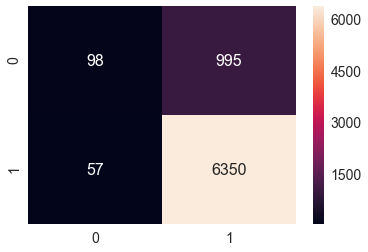

In [69]:
#Testing Accuracy on Test data

%time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Confusion Matrix of test set:\n [ [TN FP]\n [FN TP] ]\n")

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# Observation

In [ ]:
1.Here we observe that while using 25k points the heat map of confusion
 matrix is very clear and a/c to this we see that the model is perfect 
 because the TN and TP are having high values.

2.The accuracy on text data using brute force algorithm is 85.973%
 which shows that model is perfect.

# An introduction to TF-IDF =>

In [ ]:
TF-IDF stands for “Term Frequenct — Inverse Data Frequency”.

Term Frequency (tf): gives us the frequency of the word in each document in the corpus. 
It is the ratio of number of times the word appears in a document compared to the 
total number of words in that document.It increases as the number of occurrences 
of that word within the document increases. Each document has its own tf.

Inverse Data Frequency (idf)=>

Used to calculate the weight of rare words across all documents in the corpus.
The words that occur rarely in the corpus have a high IDF score. It is given by
the equation below.

# Classification of TF-IDF using Knn Algorithm (Brute Force)

In [20]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train1, y_test = train_test_split(new_final_counts
['CleanedText'].values,new_final_counts['Score'].values ,test_size=0.30,shuffle=False)

tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams
X_train_tfidf=tfidf.fit_transform(X_train)



#Normalize Data
X_traintfidf_counts = preprocessing.normalize(X_train_tfidf)
print("Train Data Size: ",X_traintfidf_counts.shape)
X_test = tfidf.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)


Train Data Size:  (17500, 379637)
Test Data Size:  (7500, 379637)
Wall time: 3.88 s


In [27]:
%time

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit
knn = KNeighborsClassifier(algorithm='brute')

# neigh = np.arange(1,100,2)

param_grid = {'n_neighbors':np.arange(1,100,2)} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting

gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_test.shape)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 50 candidates, totalling 500 fits


ValueError: Cannot have number of folds =11 greater than the number of samples: 2.

Accuracy on test set: 86.107%
Confusion Matrix of test set:
 [ [TN FP]
 [FN TP] ]



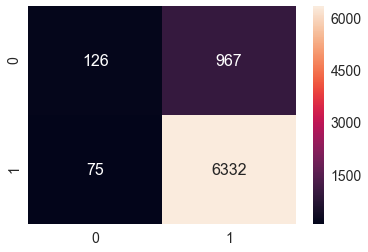

In [70]:
#Testing Accuracy on Test data

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Confusion Matrix of test set:\n [ [TN FP]\n [FN TP] ]\n")

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# Observation=>

In [ ]:
1.Here we observe that while using 25k points the heat map of confusion
  matrix is very clear and a/c to this we see that the model is perfect 
  because the TN and TP are having high values.

2.The accuracy on text data using brute force algorithm is 86.107% which
  shows that model is perfect.

# Word2vec =>

In [ ]:
word2vec is an algorithm for constructing vector representations of words, also known 
as word embeddings. The vector for each word is a semantic description of how that 
word is used in context, so two words that are used similarly in text will get 
similar vector represenations.Once you map words into vector space, you can then 
use vector math to find words that have similar semantics.

# Using Google News Word2Vectors

In [ ]:
Gensim

Gensim is a robust open-source vector space modeling and topic modeling
toolkit implemented in Python. It uses NumPy,SciPy and optionally 
Cython for performance. Gensim is specifically designed to handle 
large text collections, using datastreaming and efficient incremental 
algorithms, which differentiates it from most other scientific software
packages thatonly target batch and in-memory processing.

In [ ]:
%time

import re
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',
                                          binary=True)

In [83]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [84]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)  

In [85]:
w2v_vocub = model.wv.vocab
len(w2v_vocub)

3000000

# Avg Word2Vec Using Brute Force Algorithm

In [ ]:
1.One of the most naive but good ways to convert a sentence into a vector.
2.Convert all the words to vectors and then just take the avg of the 
vectors the resulting vector represent the sentence.

In [86]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))

393931


In [ ]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='brute')

# neigh = np.arange(1,100,2)

param_grid = {'n_neighbors':np.arange(1,100,2)} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting

gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Accuracy on test set: 85.973%
Confusion Matrix of test set:
 [ [TN FP]
 [FN TP] ]



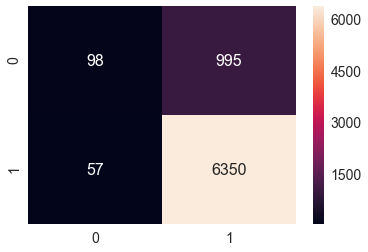

In [71]:
#Testing Accuracy on Test data

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train,y_train)

y_pred = knn.predict(X_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Confusion Matrix of test set:\n [ [TN FP]\n [FN TP] ]\n")

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# Observation

In [ ]:
1.Here we observe that while using 25k points the heat map of confusion
  matrix is very clear and a/c to this we see that the model is perfect 
  because the TN and TP are having high values.

2.The accuracy on text data using brute force algorithm is 85.973% which
  shows that model is perfect.

# Tf-idf W2Vec Using Brute Force Algorithm


In [ ]:
1.Another way to covert sentence into vectors
2.Take weighted sum of the vectors divided by the sum of all the tfidf's
i.e. (tfidf(word) x w2v(word))/sum(tfidf's)

In [87]:

# TF-IDF weighted Word2Vec
tfidf_feat = tfidf.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    

In [88]:
new_tfidf_sent_vectors=tfidf_sent_vectors[:25000]
new_final=final[:25000]

In [90]:
#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(new_tfidf_sent
_vectors,new_final['Score'].values,test_size=0.3,shuffle=False)

In [91]:
from sklearn.model_selection import TimeSeriesSplit
tscv=TimeSeriesSplit(n_splits=10)

In [93]:
from sklearn.model_selection import TimeSeriesSplit
tscv=TimeSeriesSplit(n_splits=10)

In [95]:
X_train=np.isnan(X_train)
np.where(np.isnan(X_train))
np.nan_to_num(X_train)
X_test=np.isnan(X_test)
np.where(np.isnan(X_test))
np.nan_to_num(X_test)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [96]:
%time

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit

knn = KNeighborsClassifier(algorithm='brute')

# neigh = np.arange(1,100,2)

param_grid = {'n_neighbors':np.arange(1,40,2)} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting

gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best HyperParameter:  {'n_neighbors': 1}
Best Accuracy: 85.67%


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  8.0min finished


Accuracy on test set: 85.427%
Confusion Matrix of test set:
 [ [TN FP]
 [FN TP] ]



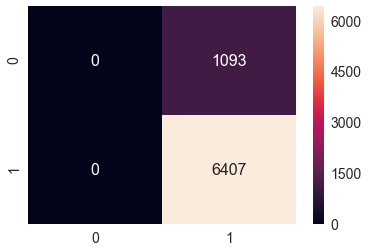

In [97]:
#Testing Accuracy on Test data

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Confusion Matrix of test set:\n [ [TN FP]\n [FN TP] ]\n")

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# Conclusions

In [ ]:
Here is the test accuracies of Feature Vectors

Bow          = 85.973%
TF-IDF       = 86.107%
Avg word2vec = 85.973%
TF-IDF W2V   = 85.427%

In [ ]:
Note: As I have taken only 25k points(due to huge training time) the accuracy 
       will not be the representive of the real accuracy

1. Best Accuracy of 85.107% is achieved by TF-IDF Featurization

2. The kd-tree and brute implementation of KNN gives relatively similar results.
   But in this I'am not using kdtree because when I pass the sparse matrix to knn 
   with kdtree algo, it can't process it, so it will internally stop using kdtree
   and uses brute force only

3. KNN is a very slow Algorithm compared to others takes a lot of time to train
   good for this dataset